# Import thư viện

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ABC

# Đọc và tiền xử lí dữ liệu

In [2]:
# Chuẩn bị dữ liệu

path ="/content/drive/MyDrive/Colab Notebooks/Data Analysis in Business 1/DATASET/ACB Historical Data.csv"
data = pd.read_csv(path, index_col='Date', parse_dates=True)

# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

# Áp dụng hàm chuyển đổi cho cột "Vol."
data["Vol."] = data["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data = data.reset_index(drop=True)

data

,Price,Open,High,Low,Vol.,Change %
0,10537.7,10477.8,10567.6,10417.9,7360000,0.0086
1,10926.9,10537.7,10956.8,10537.7,9450000,0.0369
2,10477.8,10956.8,10956.8,10477.8,8189999,-0.0411
3,10447.9,10447.9,10627.5,10328.1,9810000,-0.0029
4,10837.1,10447.9,10837.1,10447.9,8300000,0.0373
...,...,...,...,...,...,...
1506,22800.0,22700.0,22800.0,22650.0,6390000,0.0022
1507,23050.0,22800.0,23100.0,22800.0,11470000,0.0110
1508,23200.0,23050.0,23250.0,23050.0,8860000,0.0065
1509,23250.0,23200.0,23250.0,23050.0,7080000,0.0022


# Phân chia dữ liệu

In [3]:
price = data['Price'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

# Chia dữ liệu thành train test validate
train_size = int(len(price_scaled) * 0.8)
test_size = int(len(price_scaled) * 0.2)
#val_size = len(price_scaled) - train_size - test_size

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]
#val_data = price_scaled[train_size+test_size:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


# Xây dựng mô hình và train

In [4]:
# Xây dựng mô hình
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

# Add global average pooling layer
model.add(GlobalAveragePooling1D())

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_test, Y_test))

Epoch 1/100
19/19 [==============================] - 4s 97ms/step - loss: 0.0534 - val_loss: 0.0055
Epoch 2/100
19/19 [==============================] - 1s 72ms/step - loss: 0.0042 - val_loss: 0.0029
Epoch 3/100
19/19 [==============================] - 1s 56ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 4/100
19/19 [==============================] - 1s 41ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 5/100
19/19 [==============================] - 1s 41ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 6/100
19/19 [==============================] - 1s 41ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 7/100
19/19 [==============================] - 2s 108ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 8/100
19/19 [==============================] - 1s 71ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 9/100
19/19 [==============================] - 1s 78ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 10/100
19/19 [==============================] - 1s 76ms/step - loss: 0.0026 - val_loss: 0.002

# Dự báo trên tập test / validate và đánh giá mô hình

In [5]:
# Dự báo
test_predict = model.predict(X_test)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

9/9 [==============================] - 0s 6ms/step


In [6]:
# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mda = calculate_mda(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MDA trên tập test là:', test_score_mda, '%')

RMSE trên tập test là: 785.1130878535981
MAPE trên tập test là: 2.6669147020765607 %
MDA trên tập test là: 39.705882352941174 %


# Dự báo 30 ngày tiếp theo

In [7]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = price_scaled[-30:]
next_30_days = []
for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat, axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)

1/1 [==============================] - 0s 23ms/step
[[23466.928]
 [23663.826]
 [23894.777]
 [24100.656]
 [24270.586]
 [24429.709]
 [24550.701]
 [24626.617]
 [24688.719]
 [24750.383]
 [24815.182]
 [24901.85 ]
 [25014.28 ]
 [25171.375]
 [25361.123]
 [25516.852]
 [25612.488]
 [25658.223]
 [25673.197]
 [25681.754]
 [25732.477]
 [25811.46 ]
 [25864.582]
 [25858.812]
 [25804.52 ]
 [25732.088]
 [25662.377]
 [25605.594]
 [25566.85 ]
 [25553.176]]


# Chuyển các chuỗi np thành dataframe để vẽ đồ thị

In [8]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index

next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(data), len(data)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = data[:train_size][['Price']]
test_data_df = data[train_size:train_size + test_size][['Price']]
#val_data_df = data[train_size+test_size:][['Price']]

# Vẽ đồ thị

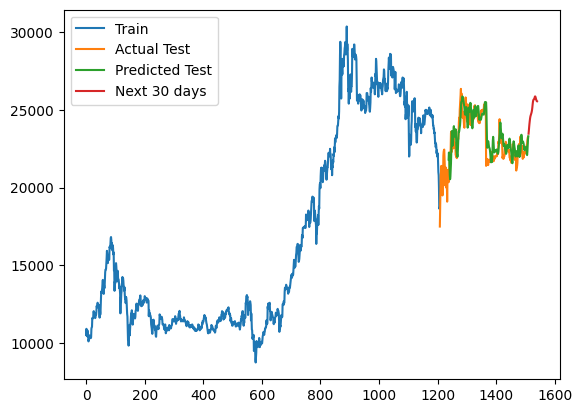

In [9]:
# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.show()

# PVS

# Đọc và tiền xử lí dữ liệu

In [10]:
# Chuẩn bị dữ liệu

path ="/content/drive/MyDrive/Colab Notebooks/Data Analysis in Business 1/DATASET/PVS Historical Data.csv"
data = pd.read_csv(path, index_col='Date', parse_dates=True)

# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

# Áp dụng hàm chuyển đổi cho cột "Vol."
data["Vol."] = data["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data = data.reset_index(drop=True)

data

,Price,Open,High,Low,Vol.,Change %
0,17292.0,16746.0,17474.0,16655.0,12030000,0.0440
1,17838.0,17383.0,17838.0,17383.0,6600000,0.0316
2,17292.0,18020.0,18020.0,17292.0,6460000,-0.0306
3,17565.0,17201.0,17656.0,16837.0,8730000,0.0158
4,17110.0,17383.0,17474.0,17019.0,6100000,-0.0259
...,...,...,...,...,...,...
1511,37400.0,37500.0,38000.0,37400.0,1840000,-0.0027
1512,37900.0,37600.0,37900.0,37100.0,2540000,0.0134
1513,38400.0,37900.0,38600.0,37900.0,3040000,0.0132
1514,38200.0,37400.0,38700.0,37400.0,1440000,-0.0052


# Phân chia dữ liệu

In [11]:
price = data['Price'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

# Chia dữ liệu thành train test validate
train_size = int(len(price_scaled) * 0.8)
test_size = int(len(price_scaled) * 0.2)

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Xây dựng mô hình và train

In [12]:
# Xây dựng mô hình
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

# Add global average pooling layer
model.add(GlobalAveragePooling1D())

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_test, Y_test))

Epoch 1/100
19/19 [==============================] - 3s 82ms/step - loss: 0.0344 - val_loss: 0.0270
Epoch 2/100
19/19 [==============================] - 1s 66ms/step - loss: 0.0075 - val_loss: 0.0070
Epoch 3/100
19/19 [==============================] - 1s 63ms/step - loss: 0.0059 - val_loss: 0.0043
Epoch 4/100
19/19 [==============================] - 1s 63ms/step - loss: 0.0060 - val_loss: 0.0078
Epoch 5/100
19/19 [==============================] - 2s 87ms/step - loss: 0.0058 - val_loss: 0.0088
Epoch 6/100
19/19 [==============================] - 1s 59ms/step - loss: 0.0057 - val_loss: 0.0071
Epoch 7/100
19/19 [==============================] - 1s 37ms/step - loss: 0.0059 - val_loss: 0.0059
Epoch 8/100
19/19 [==============================] - 1s 39ms/step - loss: 0.0058 - val_loss: 0.0054
Epoch 9/100
19/19 [==============================] - 1s 38ms/step - loss: 0.0057 - val_loss: 0.0123
Epoch 10/100
19/19 [==============================] - 1s 37ms/step - loss: 0.0058 - val_loss: 0.0050

# Dự báo trên tập test / validate và đánh giá mô hình

In [13]:
# Dự báo
test_predict = model.predict(X_test)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

9/9 [==============================] - 0s 6ms/step


In [14]:
# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mda = calculate_mda(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MDA trên tập test là:', test_score_mda, '%')

RMSE trên tập test là: 1347.04633562707
MAPE trên tập test là: 3.446149495550563 %
MDA trên tập test là: 42.124542124542124 %


# Dự báo 30 ngày tiếp theo

In [15]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = price_scaled[-30:]
next_30_days = []
for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat, axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)

1/1 [==============================] - 0s 26ms/step
[[38249.434]
 [38298.63 ]
 [38351.203]
 [38274.746]
 [38160.125]
 [38077.246]
 [37929.38 ]
 [37749.336]
 [37572.516]
 [37458.06 ]
 [37418.543]
 [37253.82 ]
 [37094.105]
 [37125.824]
 [37260.86 ]
 [37312.37 ]
 [37384.73 ]
 [37380.57 ]
 [37265.734]
 [37163.117]
 [37044.008]
 [36890.457]
 [36744.35 ]
 [36596.07 ]
 [36442.016]
 [36298.938]
 [36156.797]
 [36018.766]
 [35897.1  ]
 [35789.05 ]]


# Chuyển các chuỗi np thành dataframe để vẽ đồ thị

In [16]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index

next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(data), len(data)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = data[:train_size][['Price']]
test_data_df = data[train_size:train_size + test_size][['Price']]

# Vẽ đồ thị

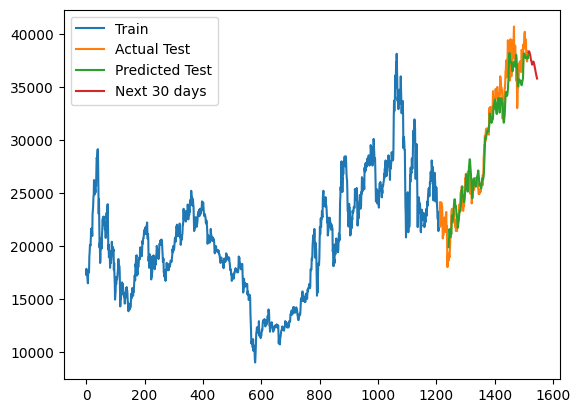

In [17]:
# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.show()

# VNM

# Đọc và tiền xử lí dữ liệu

In [18]:
# Chuẩn bị dữ liệu

path ="/content/drive/MyDrive/Colab Notebooks/Data Analysis in Business 1/DATASET/VNM Historical Data.csv"
data = pd.read_csv(path, index_col='Date', parse_dates=True)

# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

# Áp dụng hàm chuyển đổi cho cột "Vol."
data["Vol."] = data["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data = data.reset_index(drop=True)

data

,Price,Open,High,Low,Vol.,Change %
0,159039.0,151736.0,159039.0,151736.0,1500000,0.0498
1,164719.0,159039.0,166423.0,159039.0,1700000,0.0357
2,161473.0,164719.0,166342.0,160662.0,852080,-0.0197
3,158227.0,158227.0,159850.0,151898.0,1140000,-0.0201
4,150924.0,158227.0,160580.0,150924.0,1430000,-0.0462
...,...,...,...,...,...,...
1509,67000.0,68100.0,68200.0,67000.0,3510000,-0.0162
1510,67000.0,67100.0,67400.0,66300.0,3060000,0.0000
1511,68100.0,67000.0,68200.0,67000.0,2600000,0.0164
1512,67800.0,67900.0,68300.0,67800.0,2590000,-0.0044


# Phân chia dữ liệu

In [19]:
price = data['Price'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

# Chia dữ liệu thành train test validate
train_size = int(len(price_scaled) * 0.8)
test_size = int(len(price_scaled) * 0.2)

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Xây dựng mô hình và train

In [20]:
# Xây dựng mô hình
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

# Add global average pooling layer
model.add(GlobalAveragePooling1D())

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_test, Y_test))

Epoch 1/100
19/19 [==============================] - 2s 49ms/step - loss: 0.1454 - val_loss: 0.0129
Epoch 2/100
19/19 [==============================] - 1s 38ms/step - loss: 0.1454 - val_loss: 0.0129
Epoch 3/100
19/19 [==============================] - 1s 38ms/step - loss: 0.1454 - val_loss: 0.0129
Epoch 4/100
19/19 [==============================] - 1s 39ms/step - loss: 0.1454 - val_loss: 0.0129
Epoch 5/100
19/19 [==============================] - 1s 38ms/step - loss: 0.1454 - val_loss: 0.0129
Epoch 6/100
19/19 [==============================] - 1s 37ms/step - loss: 0.1454 - val_loss: 0.0129
Epoch 7/100
19/19 [==============================] - 1s 44ms/step - loss: 0.1454 - val_loss: 0.0129
Epoch 8/100
19/19 [==============================] - 1s 64ms/step - loss: 0.1454 - val_loss: 0.0129
Epoch 9/100
19/19 [==============================] - 1s 65ms/step - loss: 0.1454 - val_loss: 0.0129
Epoch 10/100
19/19 [==============================] - 1s 66ms/step - loss: 0.1454 - val_loss: 0.0129

# Dự báo trên tập test / validate và đánh giá mô hình

In [21]:
# Dự báo
test_predict = model.predict(X_test)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

9/9 [==============================] - 0s 7ms/step


In [22]:
# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mda = calculate_mda(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MDA trên tập test là:', test_score_mda, '%')

RMSE trên tập test là: 13000.771044441286
MAPE trên tập test là: 16.402317221886186 %
MDA trên tập test là: 6.25 %


# Dự báo 30 ngày tiếp theo

In [23]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = price_scaled[-30:]
next_30_days = []
for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat, axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)

1/1 [==============================] - 0s 21ms/step
[[61260.1]
 [61260.1]
 [61260.1]
 [61260.1]
 [61260.1]
 [61260.1]
 [61260.1]
 [61260.1]
 [61260.1]
 [61260.1]
 [61260.1]
 [61260.1]
 [61260.1]
 [61260.1]
 [61260.1]
 [61260.1]
 [61260.1]
 [61260.1]
 [61260.1]
 [61260.1]
 [61260.1]
 [61260.1]
 [61260.1]
 [61260.1]
 [61260.1]
 [61260.1]
 [61260.1]
 [61260.1]
 [61260.1]
 [61260.1]]


# Chuyển các chuỗi np thành dataframe để vẽ đồ thị

In [24]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index

next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(data), len(data)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = data[:train_size][['Price']]
test_data_df = data[train_size:train_size + test_size][['Price']]

# Vẽ đồ thị

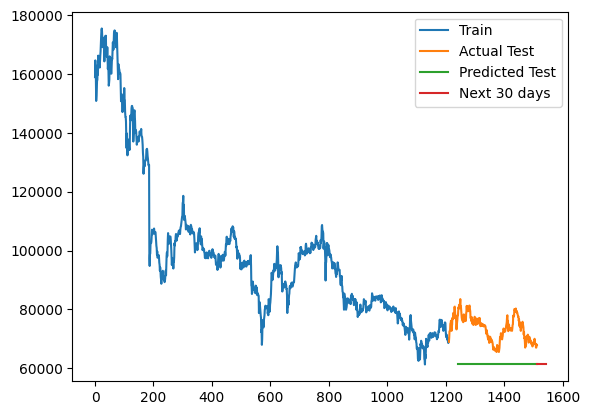

In [25]:
# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.show()